**Predicting stock price using transformer, informer and autoformer models**

- **(1) Transformer Model:**
    - Originally designed for natural language processing tasks.
    - Uses **self-attention mechanisms** to process input data.
    - Particularly effective in handling sequences of data (like time series).
    - Transformers are good at capturing long-range dependencies in data.
- **self-attention mechanisms**
  - transformer_layer = nn.TransformerEncoderLayer(... nhead=num_heads...)
  - Multi-head self-attention mechanism (nhead=num_heads):
    - allow model to look at data at diff positions and understand the dependencies between diff words (in NLP) or time steps (in time series analysis)
  - self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
    - stack multiple 'Multi-head self-attention mechanism ' so as to learn complex patterns at different scales.
  - The self-attention mechanism capture dependencies regardless of their distance in the input sequence. This contrasts with RNNs or LSTMs, where the ability to maintain information across many time steps can be limited due to vanishing gradients. **Vanishing gradient** is when gradient is too small update weights in layers to further minimize the loss function, **it is a major issue for long-term dependencies** as passing data through multiple layers will reduce the gradient further.**Transformer reduces vanishing gradient issue** as data are connected directly without going through many layers

    
- **(2) Informer Model:**
    - An extension of the Transformer model, specifically designed for time series forecasting.
    - Features a **ProbSparse self-attention mechanism**, which reduces the computational complexity significantly.
    - Efficient in handling very long sequences, making it suitable for time series forecasting.
  - **ProbSparse Self-Attention**
    -

- **(3) Autoformer Model:**
    - Another variant of the Transformer model, tailored for time series forecasting.
    - Integrates **decomposition mechanisms** to capture trends and seasonality.
    - Focuses on improving efficiency and accuracy for time series data.

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim # informer

!pip install tsfresh
!pip install ta
from tsfresh import extract_features
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
import ta

import torch.optim as optim

# Transformer
### Step 1: Fetch and Preprocess the Data
- reshape(-1,1) as PyTorch works well with numpy


In [ ]:
symbol = 'AAPL'
data = yf.download(symbol, start="2023-08-01", end="2023-11-30")
prices = data['Close'].values.reshape(-1, 1)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
prices_normalized = scaler.fit_transform(prices)

# Converting data to PyTorch Tensor
- To convert floating-point numbers to torch.FloatTensor data type
- Tensors to PyTorch is like arrays to NumPy. It has automatic differentiation

In [ ]:
prices_tensor = torch.FloatTensor(prices_normalized)

- Transformers require input in sequence form
- xs = a few past stock prices
- ys = corresponding target data (e.g. next day's stock price

- torch.stack

In [ ]:
# create sequences for training
def create_sequences(data, seq_length):
  xs,ys = [],[]
  for i in range(len(data)-seq_length-1):
    x = data[i:(i+seq_length)] # use data[0:5] to predict data[5], use data[1:6] to predict data[6]
    y=data[i+seq_length]
    xs.append(x)
    ys.append(y)
  return torch.stack(xs), torch.stack(ys)

seq_length=4
X, y = create_sequences(prices_tensor, seq_length)

In [ ]:
prices_tensor[:10]

tensor([[-0.9888],
        [-0.9900],
        [-0.9898],
        [-0.9910],
        [-0.9904],
        [-0.9906],
        [-0.9913],
        [-0.9920],
        [-0.9908],
        [-0.9903]])

In [ ]:
X[:3]

tensor([[[-0.9888],
         [-0.9900],
         [-0.9898],
         [-0.9910]],

        [[-0.9900],
         [-0.9898],
         [-0.9910],
         [-0.9904]],

        [[-0.9898],
         [-0.9910],
         [-0.9904],
         [-0.9906]]])

In [ ]:
y[:3]

tensor([[-0.9904],
        [-0.9906],
        [-0.9913]])

# DataLoader example

In [ ]:
# # Example
# data = torch.arange(1, 21)
# dataset = TensorDataset(data)
# batch_size = 5
# train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)  # Shuffle is turned off

# for i, (batch,) in enumerate(train_loader):
#     print(f"Batch {i + 1}: {batch.numpy()}")

In [ ]:
# # Example
# data = torch.arange(1, 21)
# dataset = TensorDataset(data)
# batch_size = 5
# train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  # Shuffle is turned off

# for i, (batch,) in enumerate(train_loader):
#     print(f"Batch {i + 1}: {batch.numpy()}")

In [ ]:
train_data = TensorDataset(X,y)
train_loader = DataLoader(train_data, batch_size=16, shuffle=False)


### Step 2: Define the Transformer Model
- src: source / input data
- fc = fully connected

**Common bug**
- seq_length(4) = embedding dimension = num of features of the data
- num_heads(2)  = attention heads = num of 'workers' looking at these features
- seq_length(4) need to be divisble by num_heads(2)
  - so that each worker gets equal portion and there is no confusion

In [ ]:
class TransformerModel(nn.Module): # inherts from nn.Modeul which is a base class of PyTorch with useful methods and attributes
    def __init__(self, input_dim, seq_length, num_layers, num_heads, dim_feedforward, output_dim):
        '''
        inpt_dim = num of features in input data (e.g. 1 if only closing price)
        seq_length = length of input sequence (e.g. 5 if use 5 days to predict 6th day)
        num_layers = num of layers in Transformer encoder
        num_heads = num of heads in multi-head attention mechanism
        dim_feedforward = dimension of feedforward network in transformer. Each feedforwawrd network of a transformer layer will transform input data into a vector of 2048 dimensions and then pass onto next layer. Implicitly used in nn.TransformerEncoderLayer
        output_dim = num of features in output (e.g. 1 if only predicting the next closing price)
        '''
        super(TransformerModel, self).__init__() # calling the constructor (def __init__) of nn.Module

        self.embedding = nn.Linear(input_dim, seq_length) # use linear layer as an embedding layer. Independet variable X = num of features of X + length of each sequence of X
        '''
        In NLP, embedding layer transforms discrete tokens (like words) into continuous vectors
        In time series data, embedding layer transform features (e.g. dates, categorical data) into continuous vector
        '''

        transformer_layer = nn.TransformerEncoderLayer(d_model=seq_length, nhead=num_heads, dim_feedforward=dim_feedforward)
        '''
        a single transformer layer, that includes
          - a multi-head self-attention mechanism
          - a feedforward neural network

        '''

        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        '''
        encoder to stack multiple transformer layers

        (q) what is encoder?
        - in 1 sentence, it is to capture the short and long term patter of the time series stock price, and this is done by stacking transformer layers
        - it is the part of a model that processes input data
        - primary role is to transform input data into a format (typically by stacking layers) suitable for further processing
        - example
          - input data (e.g.stock prices), represent each data using high-dimension vectors (i.e. multiple numerical features)
          - stacking identifical transformer layers
          - as data pass through the stack layers, the data undergo hierarchical transformation.
          - Lower layers capture local dependencies, while higher layers capture more global dependencies and abstractions.
            - lower/earlier layer: patterns in input data that are close to each other in terms of position in a sequence, e.g. short term impact of stock price
            - higher/later layer: e.g. long term impact of stop price
          - output: extracting the important information from the important data

        (q) what is decoder
        - decoder is not used for time-series data
        '''

        self.fc_out = nn.Linear(seq_length, output_dim)
        '''
        - output layer to transform 'output of transformer encoder (i.e. stacked transformer
        layers)' to 'final output of desired dimensions'
        - output layer gives the final output /  actual prediction of the model
        '''

    def forward(self, src):
      '''
      a special method in PyTorch to process input (src) and returns output

      forward function is only called implicitly.  This is due to how nn.Module class is designed

      (usage 1: training)
      - y_pred = model(x_batch) internally becomes y_pred = model.forward(x_batch)
      (usage 2: predicting)
      - when we write "predictions = model(input_data)", it internally becomes "predictions = model.forward(input_data)
      '''
      src = self.embedding(src)
      src = src.permute(1, 0, 2)  # Reshape for transformer. Reshape input tensor to fit requirements of transformer encoder, which is this format (sequence length, batch size, features)
      output = self.transformer(src)
      output = output.permute(1, 0, 2)  # Reshape back
      self.fc_out(output)
      return output[:,-1,:].squeeze(-1)

# Model initialization with adjusted seq_length
input_dim = 1  # As we are using only closing prices
# seq_length=4 # defined previously. use 4-days prices as input (note: seq_length needs to be a multiple of num_heads)
num_layers=2 # num of layers in Transformer encoder
num_heads = 2 # num of heads in attention mechanism (note: seq_length needs to be a multiple of num_heads)
dim_feedforward=10 # dimension of feedforward network in transformer
output_dim = 1  # Predicting the next closing price
model = TransformerModel(input_dim, seq_length, num_layers, num_heads, dim_feedforward, output_dim)


###Example of embedding layer
- there are 7 categories, and we want to represent them using 5 features
- lets say context is monday to sunday, representing by 0 to 6. Input data is 0,1,2,3,4,5,6,0,1,2,... and so on.
- embedding layer will give each of the 5 features a embedding vector value
- In this case, Monday is represented by [-0.4095,  1.0421,  1.2239, -1.4228,  0.5698]

In [ ]:
# import torch
# import torch.nn as nn

# # Create an embedding layer with 7 categories (days of the week) and 5 dimensions
# embedding_layer = nn.Embedding(num_embeddings=7, embedding_dim=5)

# # Example input - days of the week (0 to 6)
# days_of_week = torch.tensor([0, 1, 2, 3, 4, 5, 6])  # Monday to Sunday

# # Specify the number of repetitions
# num_repetitions = 100000  # You can change this as needed

# # Repeat the days_of_week tensor to create a long series
# repeated_data = days_of_week.repeat(num_repetitions)

# # Use the embedding layer to get continuous vectors
# embedded_days = embedding_layer(repeated_data)

# # Calculate the average embedding vectors for each day
# import torch

# # Define the number of days (7) and the embedding dimension (5)
# num_days = 7
# embedding_dim = 5

# # Initialize a tensor to store the mean vectors for each day
# mean_embeddings = torch.zeros(num_days, embedding_dim)

# # Loop through the embedded representations and accumulate them for each day
# for i in range(num_days):
#     day_indices = (repeated_data == i).nonzero()  # Find indices where the day matches
#     day_embeddings = embedded_days[day_indices].mean(dim=0)  # Calculate the mean embedding vector for the day
#     mean_embeddings[i] = day_embeddings

# # Print the mean embedding vectors for each day
# print("Mean Embedding Vectors:")
# print(mean_embeddings)


### Step 3: Train the Model


**Potential bug**
- squeeze(-1) is used to remove the last dimension is the last dimension has size 1 which may arise in some calculation

In [ ]:
# UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
#   return F.mse_loss(input, target, reduction=self.reduction)
# ---------------------------------------------------------------------------
# RuntimeError                              Traceback (most recent call last)
# <ipython-input-56-c3b4bd9282d1> in <cell line: 16>()
#      14
#      15 # Train the model
# ---> 16 train(model, train_loader, optimizer, criterion, epochs=50)

# 5 frames
#      71     if has_torch_function(tensors):
#      72         return handle_torch_function(broadcast_tensors, tensors, *tensors)
# ---> 73     return _VF.broadcast_tensors(tensors)  # type: ignore[attr-defined]
#      74
#      75

# RuntimeError: The size of tensor a (4) must match the size of tensor b (16) at non-singleton dimension 1

In [ ]:
# # Fix bug
# for x_batch, y_batch in train_loader:
#   y_pred = model(x_batch)
#   print(y_pred.shape)
#   print(y_batch.shape)

# # torch.Size([16, 4, 1])
# # torch.Size([16, 1])
# # torch.Size([16, 4, 1])
# # torch.Size([16, 1])
# # torch.Size([16, 4, 1])

# '''
# The issue is that y_pred is 3-dimension, but y_batch is 2-dimension
# batch_size=16, seq_length=4, 1 is the predicted next-day stock price

# Solution
# def forward():
#   return output[:, -1, :].squeeze(-1) # return only the last column and squeeze it into 1
# '''

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # learning rate (i.e. step size of loss function), 0.001 is a common lr

def train(model, train_loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        if epoch == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item()}')
        elif epoch == epochs - 1:
            print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Train the model
train(model, train_loader, optimizer, criterion, epochs=50)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 1.2281991243362427
Epoch 2, Loss: 1.2107212543487549
Epoch 3, Loss: 1.1929935216903687
Epoch 4, Loss: 1.1755821704864502
Epoch 5, Loss: 1.1579862833023071
Epoch 6, Loss: 1.1404780149459839
Epoch 7, Loss: 1.1231157779693604
Epoch 8, Loss: 1.1053427457809448
Epoch 9, Loss: 1.0884754657745361
Epoch 10, Loss: 1.0696972608566284
Epoch 11, Loss: 1.0518616437911987
Epoch 12, Loss: 1.033868670463562
Epoch 13, Loss: 1.0153820514678955
Epoch 14, Loss: 0.9977076053619385
Epoch 15, Loss: 0.9790142774581909
Epoch 16, Loss: 0.961455225944519
Epoch 17, Loss: 0.9453724026679993
Epoch 18, Loss: 0.9281316995620728
Epoch 19, Loss: 0.9121583700180054
Epoch 20, Loss: 0.8961325883865356
Epoch 21, Loss: 0.8800064325332642
Epoch 22, Loss: 0.8659438490867615
Epoch 23, Loss: 0.8527446389198303
Epoch 24, Loss: 0.8381292819976807
Epoch 25, Loss: 0.8241408467292786
Epoch 26, Loss: 0.8111900687217712
Epoch 27, Loss: 0.7991932034492493
Epoch 28, Loss: 0.7866167426109314
Epoch 29, Loss: 0.7739750146865

# Prediction using old data

In [ ]:
X_new, y_new = X,y
model.eval() # Prepare the model for evaluation

all_predictions = []
all_actuals = []

def predict(model, input_data):
    model.eval()  # Switch the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        prediction = model(input_data)  # Get the model's prediction
    return prediction

with torch.no_grad():
    for i in range(len(X_new)):
        single_prediction = predict(model, X_new[i].unsqueeze(0))
        predicted_value = single_prediction.squeeze().numpy()[-1]  # Extract the last element
        all_predictions.append(predicted_value)
        all_actuals.append(y_new[i].item())

# Convert predictions and actuals to the original scale
all_predictions = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1))
all_actuals = scaler.inverse_transform(np.array(all_actuals).reshape(-1, 1))

# Calculate MSE and MAE
mse = mean_squared_error(all_actuals, all_predictions)
mae = mean_absolute_error(all_actuals, all_predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 34.68873481081023
Mean Absolute Error: 4.367219932139635


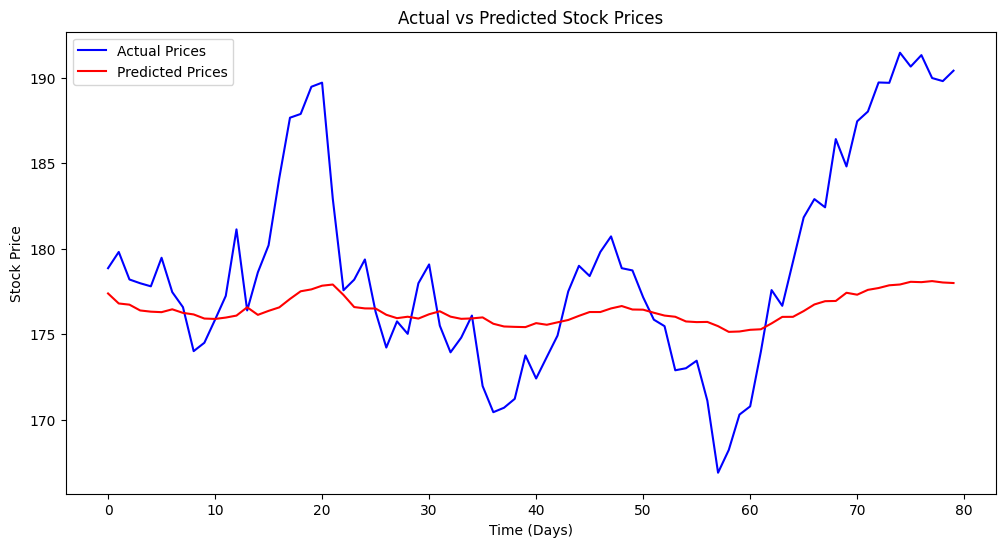

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(all_actuals, label='Actual Prices', color='blue')
plt.plot(all_predictions, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time (Days)')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Step 4: Making Predictions and Evaluation (using new data)


In [ ]:
symbol = 'AAPL'
new_data = yf.download(symbol, start="2023-12-01", end="2023-12-31")
new_prices = new_data['Close'].values.reshape(-1, 1)

new_prices_normalized = scaler.transform(new_prices)
new_prices_tensor = torch.FloatTensor(new_prices_normalized)

X_new, y_new = create_sequences(new_prices_tensor, seq_length)

model.eval() # Prepare the model for evaluation

all_predictions = []
all_actuals = []

def predict(model, input_data):
    model.eval()  # Switch the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        prediction = model(input_data)  # Get the model's prediction
    return prediction

with torch.no_grad():
    for i in range(len(X_new)):
        single_prediction = predict(model, X_new[i].unsqueeze(0))
        predicted_value = single_prediction.squeeze().numpy()[-1]  # Extract the last element
        all_predictions.append(predicted_value)
        all_actuals.append(y_new[i].item())

# Convert predictions and actuals to the original scale
all_predictions = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1))
all_actuals = scaler.inverse_transform(np.array(all_actuals).reshape(-1, 1))

# Calculate MSE and MAE
mse = mean_squared_error(all_actuals, all_predictions)
mae = mean_absolute_error(all_actuals, all_predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')


[*********************100%%**********************]  1 of 1 completed
Mean Squared Error: 34.68873481081023
Mean Absolute Error: 4.367219932139635


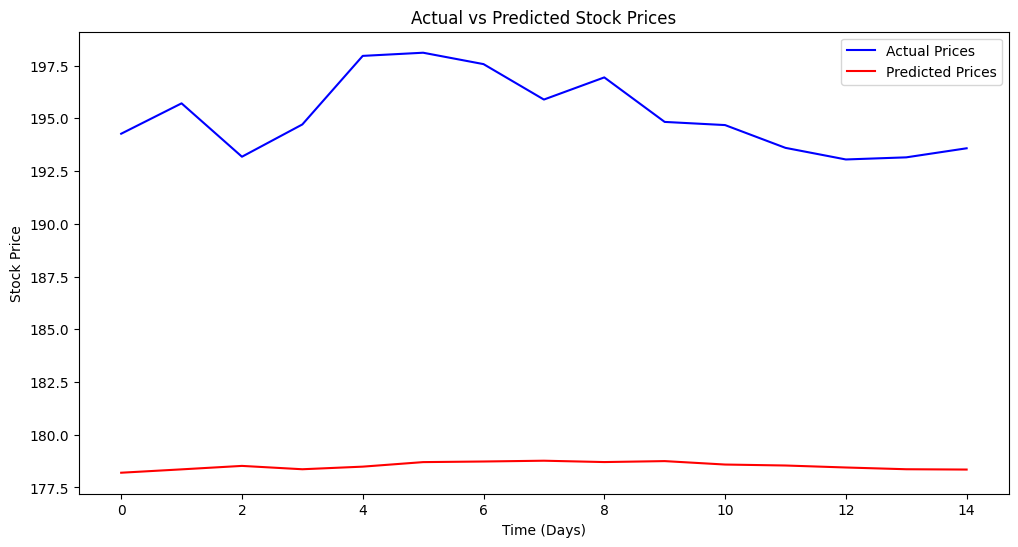

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(all_actuals, label='Actual Prices', color='blue')
plt.plot(all_predictions, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time (Days)')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Step 5: improving model
- Underfitting seem to be the problem. Let's try to increase model complexity
- Loop through different model specifications
- Input = prices_tensor (it contains the raw stock price)

In [ ]:
def create_sequences(data, seq_length):
  xs,ys = [],[]
  for i in range(len(data)-seq_length-1):
    x = data[i:(i+seq_length)] # use data[0:5] to predict data[5], use data[1:6] to predict data[6]
    y=data[i+seq_length]
    xs.append(x)
    ys.append(y)
  return torch.stack(xs), torch.stack(ys)


class TransformerModel(nn.Module): # inherts from nn.Modeul which is a base class of PyTorch with useful methods and attributes
    def __init__(self, input_dim, seq_length, num_layers, num_heads, dim_feedforward, output_dim):
        '''
        inpt_dim = num of features in input data (e.g. 1 if only closing price)
        seq_length = length of input sequence (e.g. 5 if use 5 days to predict 6th day)
        num_layers = num of layers in Transformer encoder
        num_heads = num of heads in multi-head attention mechanism
        dim_feedforward = dimension of feedforward network in transformer. Each feedforwawrd network of a transformer layer will transform input data into a vector of 2048 dimensions and then pass onto next layer. Implicitly used in nn.TransformerEncoderLayer
        output_dim = num of features in output (e.g. 1 if only predicting the next closing price)
        '''
        super(TransformerModel, self).__init__() # calling the constructor (def __init__) of nn.Module

        self.embedding = nn.Linear(input_dim, seq_length) # use linear layer as an embedding layer. Independet variable X = num of features of X + length of each sequence of X
        '''
        In NLP, embedding layer transforms discrete tokens (like words) into continuous vectors
        In time series data, embedding layer transform features (e.g. dates, categorical data) into continuous vector
        '''

        transformer_layer = nn.TransformerEncoderLayer(d_model=seq_length, nhead=num_heads, dim_feedforward=dim_feedforward)
        '''
        a single transformer layer, that includes
          - a multi-head self-attention mechanism
          - a feedforward neural network

        '''

        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        '''
        encoder to stack multiple transformer layers

        (q) what is encoder?
        - in 1 sentence, it is to capture the short and long term patter of the time series stock price, and this is done by stacking transformer layers
        - it is the part of a model that processes input data
        - primary role is to transform input data into a format (typically by stacking layers) suitable for further processing
        - example
          - input data (e.g.stock prices), represent each data using high-dimension vectors (i.e. multiple numerical features)
          - stacking identifical transformer layers
          - as data pass through the stack layers, the data undergo hierarchical transformation.
          - Lower layers capture local dependencies, while higher layers capture more global dependencies and abstractions.
            - lower/earlier layer: patterns in input data that are close to each other in terms of position in a sequence, e.g. short term impact of stock price
            - higher/later layer: e.g. long term impact of stop price
          - output: extracting the important information from the important data

        (q) what is decoder
        - decoder is not used for time-series data
        '''

        self.fc_out = nn.Linear(seq_length, output_dim)
        '''
        - output layer to transform 'output of transformer encoder (i.e. stacked transformer
        layers)' to 'final output of desired dimensions'
        - output layer gives the final output /  actual prediction of the model
        '''

    def forward(self, src):
      '''
      a special method in PyTorch to process input (src) and returns output

      forward function is only called implicitly.  This is due to how nn.Module class is designed

      (usage 1: training)
      - y_pred = model(x_batch) internally becomes y_pred = model.forward(x_batch)
      (usage 2: predicting)
      - when we write "predictions = model(input_data)", it internally becomes "predictions = model.forward(input_data)
      '''
      src = self.embedding(src)
      src = src.permute(1, 0, 2)  # Reshape for transformer. Reshape input tensor to fit requirements of transformer encoder, which is this format (sequence length, batch size, features)
      output = self.transformer(src)
      output = output.permute(1, 0, 2)  # Reshape back
      self.fc_out(output)
      return output[:,-1,:].squeeze(-1)

def train(model, train_loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        if epoch == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item()}')
        elif epoch == epochs - 1:
            print(f'Epoch {epoch+1}, Loss: {loss.item()}')

def predict(model, input_data):
    model.eval()  # Switch the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        prediction = model(input_data)  # Get the model's prediction
    return prediction


def set_seed(seed_value):
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def loop(seq_length=4, batch_size=16, input_dim = 1, num_layers=2,
         num_heads = 2, dim_feedforward=10, output_dim = 1, lr=0.001,
         epochs=50): # (note: seq_length needs to be a multiple of num_heads)

    ################################# train model
    set_seed(0)

    X, y = create_sequences(prices_tensor, seq_length)
    train_data = TensorDataset(X,y)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)

    model = TransformerModel(input_dim, seq_length, num_layers, num_heads, dim_feedforward, output_dim)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # learning rate (i.e. step size of loss function), 0.001 is a common lr

    train(model, train_loader, optimizer, criterion, epochs=epochs)

    ################################### predict training data
    X, y = train_X, train_y
    model.eval() # Prepare the model for evaluation

    all_predictions = []
    all_actuals = []

    with torch.no_grad():
        for i in range(len(X)):
            single_prediction = predict(model, X[i].unsqueeze(0))
            predicted_value = single_prediction.squeeze().numpy()[-1]  # Extract the last element
            all_predictions.append(predicted_value)
            all_actuals.append(y[i].item())

    # Convert predictions and actuals to the original scale
    all_predictions = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1))
    all_actuals = scaler.inverse_transform(np.array(all_actuals).reshape(-1, 1))

    # Calculate MSE and MAE
    mse = mean_squared_error(all_actuals, all_predictions)
    mae = mean_absolute_error(all_actuals, all_predictions)

    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')

    plt.figure(figsize=(12, 6))
    plt.plot(all_actuals, label='Actual Prices', color='blue')
    plt.plot(all_predictions, label='Predicted Prices', color='red')
    plt.title('Actual vs Predicted Stock Prices (training data)')
    plt.xlabel('Time (Days)')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    ################################### predict new data
    X, y = X_new, y_new
    model.eval() # Prepare the model for evaluation

    all_predictions = []
    all_actuals = []

    with torch.no_grad():
        for i in range(len(X)):
            single_prediction = predict(model, X[i].unsqueeze(0))
            predicted_value = single_prediction.squeeze().numpy()[-1]  # Extract the last element
            all_predictions.append(predicted_value)
            all_actuals.append(y[i].item())

    # Convert predictions and actuals to the original scale
    all_predictions = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1))
    all_actuals = scaler.inverse_transform(np.array(all_actuals).reshape(-1, 1))

    # Calculate MSE and MAE
    mse = mean_squared_error(all_actuals, all_predictions)
    mae = mean_absolute_error(all_actuals, all_predictions)

    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')

    plt.figure(figsize=(12, 6))
    plt.plot(all_actuals, label='Actual Prices', color='blue')
    plt.plot(all_predictions, label='Predicted Prices', color='red')
    plt.title('Actual vs Predicted Stock Prices (actual data)')
    plt.xlabel('Time (Days)')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

seq_length = 4

# training data
symbol = 'AAPL'
data = yf.download(symbol, start="2023-01-01", end="2023-06-01")
prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1)) # diff
prices_normalized = scaler.fit_transform(prices)
prices_tensor = torch.FloatTensor(prices_normalized)
train_X, train_y = create_sequences(prices_tensor, seq_length)

# new data
new_data = yf.download(symbol, start="2023-06-02", end="2023-12-31")
new_prices = new_data['Close'].values.reshape(-1, 1)
new_prices_normalized = scaler.transform(new_prices)
new_prices_tensor = torch.FloatTensor(new_prices_normalized)
X_new, y_new = create_sequences(new_prices_tensor, seq_length)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they h

Epoch 1, Loss: 1.9162808656692505
Epoch 50, Loss: 1.0262751579284668
Mean Squared Error: 79.6297006918298
Mean Absolute Error: 7.486346340041534


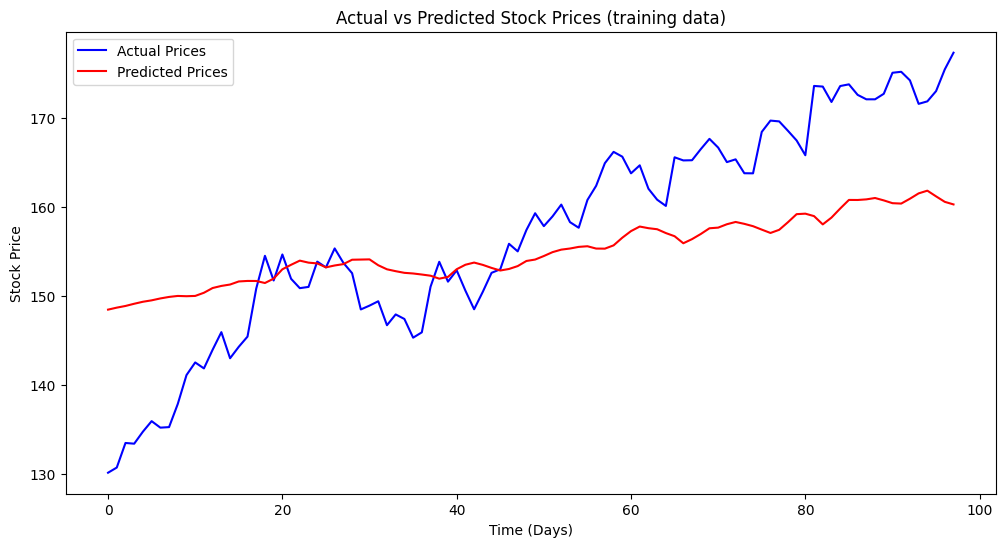

Mean Squared Error: 289.70674467003215
Mean Absolute Error: 16.475787471572527


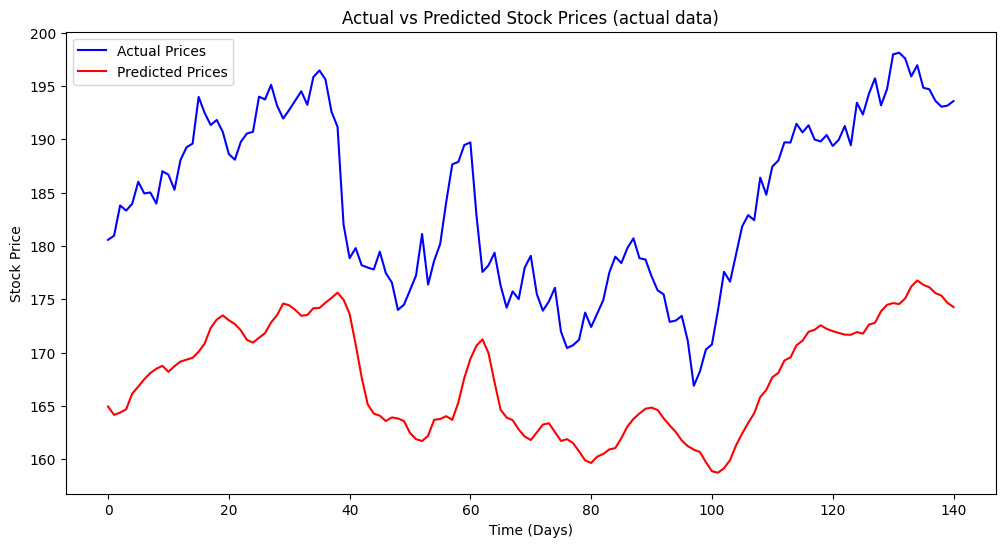

In [ ]:
loop()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([14, 1])) that is different to the input size (torch.Size([14, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they

Epoch 1, Loss: 1.6811084747314453
Epoch 50, Loss: 0.3118690848350525
Mean Squared Error: 78.12308525001055
Mean Absolute Error: 6.880998865637765


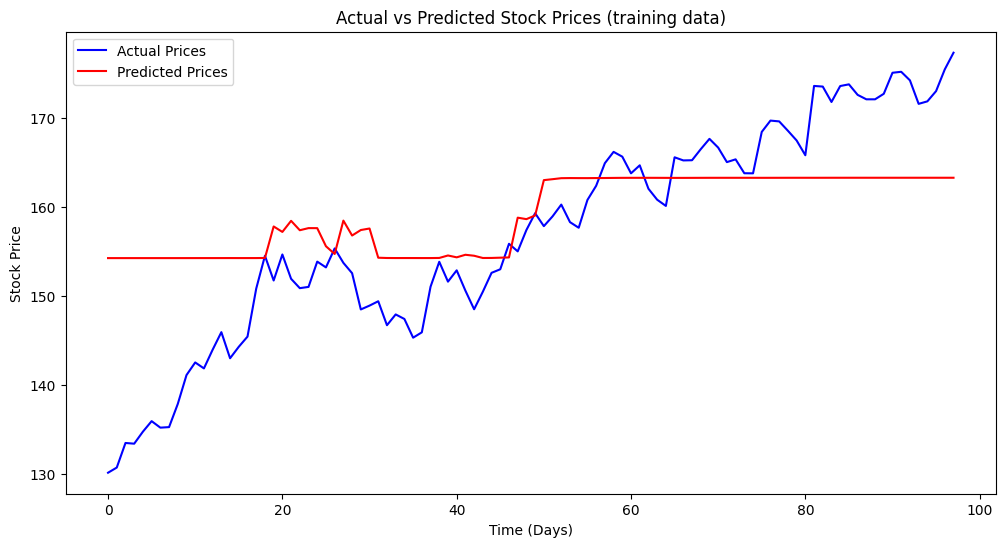

Mean Squared Error: 501.7400139513074
Mean Absolute Error: 20.88439684830402


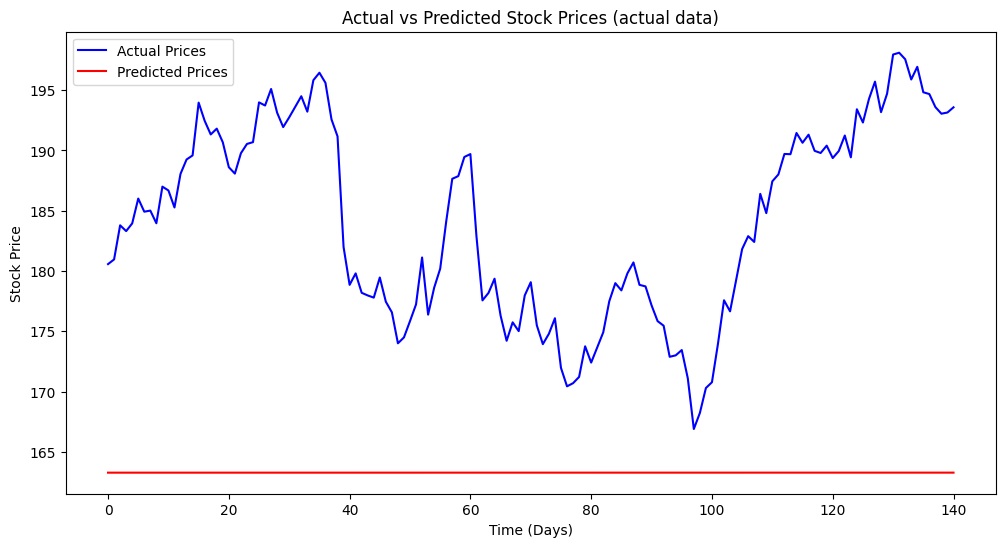

In [ ]:
loop(seq_length = 8, num_layers = 4, dim_feedforward = 2048, epochs = 50, lr = 0.001 )

# Feature engineering libraries
-  tsfresh
  - automatically calculates a large number of time series characteristics, which can then be used to train machine learning models.


# tsfresh
- a library to automatically extract features from **time series data**. These features are relevant characteristics to improve **machine learning model**
- It does
  - **Feature extraction**: extracts features
    - basic features: mean, median, standard deviation
    - time-based patterns: autocorrelation
    - complex features: Fourier transforms, time-based patterns,
    - extract over 700 features
    -  in stock price prediction, features like **lagged values, rolling means/medians, volatility measures (rolling standard deviation), momentum indicators, and autocorrelation, features that capture ternds/seasonality/cyclical patterns, fourier fetaures** features are often found to be significant
    - (Q) are these included in the extracted features?
      - original price itself (no)
      - lagged price (no)
      - Rolling Means/Medians and Volatility Measures (no, but tsfresh has moving averages and standard deviation)
      -Momentum Indicators (no)
      - Autocorrelation Features (yes)
      - Features Capturing Trends/Seasonality/Cyclical Pattern (yes, e.g. fourier features)

  - **efficient calculation**: process multiple time series efficiently, using parallelization to speed up the computation
  - **relevance testing**: perform hypothesis tests to determine which features are statistically significant and relevant to the target variable you're trying to predict.
  - **Imputation**: handle any missing values that result from the extraction process.

## How to use tsfresh?
- **prepare data**: data in pandas DataFrame. A column for time, columns for time series data, columns for values you want to extract features from
- **Feature Extraction**: Call extract_features() on your DataFrame. You can specify which kinds of features to extract and customize other parameters.
- **Imputation**: Use impute() to handle any NaNs or infinite values in your extracted features.
  - **For finite values**: If a feature has finite values but also contains missing values (NaNs), tsfresh will fill these NaNs with the median of the finite values in that feature.
  - **For features with all missing values**: If a feature consists entirely of NaNs (which might happen if a particular feature couldn't be calculated for your dataset), tsfresh will fill these with zeros.
- **Feature Selection**: Optionally, you can use select_features() to choose the most relevant features based on the hypothesis tests and a target variable
  - **Mann-Whitney U test**:
    - non-parametric test used to compare two independent samples
    - e.g. Group A Observations: 3, 6. Group B Observations: 2, 4, 5
    - **ranking**: combine all observations from both groups (3, 6, 2, 4, 5.), rank them in ascending order "2 (rank 1), 3 (rank 2), 4 (rank 3), 5 (rank 4), 6 (rank 5)."
  - H0: no relationship between a feature and target variable (tmr's stock price)
  - 5% significance
    - **U Statistic**:
      - Group A (3, 6) has ranks 2 and 5
      - Group B (2, 4, 5) has ranks 1, 3, 4
      - For group A: Sum of Ranks = 2 + 5 = 7. U-statistics (U1) = 7 - (2 * (2 + 1) / 2) = 7 - 3 = 4
      - For group B: Sum of Ranks = 1 + 3 + 4 = 8. U-stataistics (U2) =  8 - (3 * (3 + 1) / 2) = 8 - 6 = 2
    - **test statistics**: U = min(U1, U2) = min(4, 2) = 2
    - **p-value**:
      - **for small sample size**
        - **Enumerate All Combinations**: List all possible ways the ranks could be divided between the two groups.
        - **Calculate U for Each Combination**: For each combination, calculate the U statistic.
        - **Count Extreme Values**: Count how many times a value as extreme or more extreme than the observed U statistic occurs.
        - **Calculate P-value**: p-value is the proportion of these extreme occurrences out of all possible combinations. If indeed 2 groups are similar, then we would expect very few extreme combinations, hence low p-value
      - **for large sample size (30 data)**
        - u statistics is approximated to a normal distribution. Convert u statistics to a z-score = (U - mean)/ std.
        - mean = (n1 x n2)/2
          - n1, n2 = num of data in group A, group B
        - std = sqrt( [n1 x n2 x (n1+n2+1)] /12)
  - Use **Benjamini-Yekutieli procedure** to adjsut p-values to account for the fact that multiple comparisons (e.g. multiple Mann-Whitney U tests for different features) increase the chance of finding falsely significant results.
    - **Order P-values**:  several tests, each producing a p-value. list these p-values in ascending order.
    - **Adjustment**: calc adjusted p_value for each test, e.g. 3rd smallest p-value in a set of 10 test is 0.04, adjusted p-value = 0.04 x 10/3 * adjustment factor
    - **thresholding**: adjusted p-value below threshold (e.g. 5%) are statistically significant
- **Use Extracted Features**: Use the extracted (and selected) features as input for your machine learning models.

- (q) what is fourier features?
- (a) Fourier features are derived from the Fourier Transform, a mathematical technique that transforms a time series into a combination of sine and cosine waves, essentially breaking it down into its frequency components

In [ ]:
symbol = 'AAPL'
data = yf.download(symbol, start="2023-01-01", end="2023-06-01")['Close']
data = data.reset_index()

[*********************100%%**********************]  1 of 1 completed


In [ ]:
data = data.reset_index()
data = data.rename(columns={'index':'id'})

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
data

,id,Date,Close
0,0,2023-01-03,125.070000
1,1,2023-01-04,126.360001
2,2,2023-01-05,125.019997
3,3,2023-01-06,129.619995
4,4,2023-01-09,130.149994
...,...,...,...
98,98,2023-05-24,171.839996
99,99,2023-05-25,172.990005
100,100,2023-05-26,175.429993
101,101,2023-05-30,177.300003


In [ ]:
data['Date'] = pd.to_datetime(data['Date'])


In [ ]:
data

,id,Date,Close
0,0,2023-01-03,125.070000
1,1,2023-01-04,126.360001
2,2,2023-01-05,125.019997
3,3,2023-01-06,129.619995
4,4,2023-01-09,130.149994
...,...,...,...
98,98,2023-05-24,171.839996
99,99,2023-05-25,172.990005
100,100,2023-05-26,175.429993
101,101,2023-05-30,177.300003


In [ ]:
data = data.rename(columns={'Date': 'time'})
extracted_features = extract_features(data, column_id='id', column_sort='time')

Feature Extraction: 100%|██████████| 103/103 [00:04<00:00, 22.14it/s]


In [ ]:
extracted_features['lag_0'] = data['Close'].shift(1).reset_index(drop=True)
extracted_features['lag_1'] = data['Close'].shift(1).reset_index(drop=True)
extracted_features['lag_2'] = data['Close'].shift(2).reset_index(drop=True)
extracted_features['lag_3'] = data['Close'].shift(3).reset_index(drop=True)
extracted_features['rolling_mean'] = data['Close'].rolling(window=5, min_periods=1).mean().reset_index(drop=True)
extracted_features['rolling_median'] = data['Close'].rolling(window=5, min_periods=1).median().reset_index(drop=True)
extracted_features['sma_5'] = ta.trend.sma_indicator(data['Close'], window=5).reset_index(drop=True)
extracted_features['ema_5'] = ta.trend.ema_indicator(data['Close'], window=5).reset_index(drop=True)
extracted_features['rsi'] = ta.momentum.rsi(data['Close'], window=14).reset_index(drop=True)

macd = ta.trend.MACD(data['Close'])
extracted_features['macd'] = macd.macd().reset_index(drop=True)
extracted_features['macd_signal'] = macd.macd_signal().reset_index(drop=True)

In [ ]:
imputed_features = impute(extracted_features) # for any missing features,
y = data['Close'].shift(-1).dropna() # use today's features to predict tmr's stock price
aligned_features = imputed_features.iloc[:-1]

In [ ]:
y = y.reset_index(drop=True)

In [ ]:
assert len(aligned_features) == len(y), "The lengths of features and target variable must be equal"
selected_features = select_features(aligned_features, y)

In [ ]:
selected_features['Close']=data['Close']

In [ ]:
selected_features_raw = selected_features
selected_features = selected_features_raw

In [ ]:
# selected_features = selected_features[
#     ['Close__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)',
#     'Close__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)',
#     'Close__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)',
#     'Close__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)',
#     'Close__abs_energy',
#     'ema_5', 'rolling_mean', 'sma_5', 'lag_0','rolling_median', 'lag_2', 'lag_3',
#     'macd_signal', 'macd', 'rsi'
# ]]

selected_features = selected_features[['lag_0','lag_2','lag_3']]

In [ ]:
selected_features

,lag_0,lag_2,lag_3
0,125.070000,125.070000,125.070000
1,125.070000,125.070000,125.070000
2,126.360001,125.070000,125.070000
3,125.019997,126.360001,125.070000
4,129.619995,125.019997,126.360001
...,...,...,...
97,174.199997,175.160004,175.050003
98,171.559998,174.199997,175.160004
99,171.839996,171.559998,174.199997
100,172.990005,171.839996,171.559998


- Close__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)
  - Continuous Wavelet Transform (CWT): a tool to decompose a signal into wavelets (varying in frequency and amplitude)
  - w_20 means wdith of 20 to capture smoother features
- Close__abs_energy
  - square of close price

## Use 'selected_features' in the transformer model

In [ ]:
seq_length=4
batch_size=16
# input_dim defined later
num_layers=2
num_heads = 2
dim_feedforward=10
output_dim = 1
lr=0.001
epochs=50

In [ ]:
selected_features

,lag_0,lag_2,lag_3
0,125.070000,125.070000,125.070000
1,125.070000,125.070000,125.070000
2,126.360001,125.070000,125.070000
3,125.019997,126.360001,125.070000
4,129.619995,125.019997,126.360001
...,...,...,...
97,174.199997,175.160004,175.050003
98,171.559998,174.199997,175.160004
99,171.839996,171.559998,174.199997
100,172.990005,171.839996,171.559998


In [ ]:
def create_sequences(input_data, target_data, seq_length):
    xs, ys = [], []
    for i in range(len(input_data) - seq_length):
        x = input_data[i:(i + seq_length)].tolist()  # Convert window slice to list
        y = target_data[i + seq_length]  # Next value to be predicted
        xs.append(x)
        ys.append(y)
    return torch.FloatTensor(xs), torch.FloatTensor(ys)

In [ ]:
scalers = []
selected_features_scaled = np.zeros_like(selected_features)

for i in range(selected_features.shape[1]):
  scaler = MinMaxScaler(feature_range=(-1,1))
  feature_column = selected_features.iloc[:, i].values.reshape(-1, 1)
  scaled_feature = scaler.fit_transform(feature_column)
  scalers.append(scaler)
  selected_features_scaled[:, i] = scaled_feature.reshape(-1)

selected_features_tensor = torch.FloatTensor(selected_features_scaled)

In [ ]:
target = data['Close'].shift(-1).dropna().values
len(target)

102

In [ ]:
target_scaler = MinMaxScaler(feature_range=(-1, 1))
target_scaled = target_scaler.fit_transform(target.reshape(-1, 1))

In [ ]:
target_tensor = torch.FloatTensor(target_scaled)
X_seq, y_seq = create_sequences(selected_features_tensor, target_tensor, seq_length)
train_data = TensorDataset(X_seq, y_seq)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)

In [ ]:
input_dim = selected_features.shape[1]  # Number of features

In [ ]:
class TransformerModel(nn.Module): # inherts from nn.Modeul which is a base class of PyTorch with useful methods and attributes
    def __init__(self, input_dim, seq_length, num_layers, num_heads, dim_feedforward, output_dim):
        '''
        inpt_dim = num of features in input data (e.g. 1 if only closing price)
        seq_length = length of input sequence (e.g. 5 if use 5 days to predict 6th day)
        num_layers = num of layers in Transformer encoder
        num_heads = num of heads in multi-head attention mechanism
        dim_feedforward = dimension of feedforward network in transformer. Each feedforwawrd network of a transformer layer will transform input data into a vector of 2048 dimensions and then pass onto next layer. Implicitly used in nn.TransformerEncoderLayer
        output_dim = num of features in output (e.g. 1 if only predicting the next closing price)
        '''
        super(TransformerModel, self).__init__() # calling the constructor (def __init__) of nn.Module

        self.embedding = nn.Linear(input_dim, seq_length) # use linear layer as an embedding layer. Independet variable X = num of features of X + length of each sequence of X
        '''
        In NLP, embedding layer transforms discrete tokens (like words) into continuous vectors
        In time series data, embedding layer transform features (e.g. dates, categorical data) into continuous vector
        '''

        transformer_layer = nn.TransformerEncoderLayer(d_model=seq_length, nhead=num_heads, dim_feedforward=dim_feedforward)
        '''
        a single transformer layer, that includes
          - a multi-head self-attention mechanism
          - a feedforward neural network

        '''

        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        '''
        encoder to stack multiple transformer layers

        (q) what is encoder?
        - in 1 sentence, it is to capture the short and long term patter of the time series stock price, and this is done by stacking transformer layers
        - it is the part of a model that processes input data
        - primary role is to transform input data into a format (typically by stacking layers) suitable for further processing
        - example
          - input data (e.g.stock prices), represent each data using high-dimension vectors (i.e. multiple numerical features)
          - stacking identifical transformer layers
          - as data pass through the stack layers, the data undergo hierarchical transformation.
          - Lower layers capture local dependencies, while higher layers capture more global dependencies and abstractions.
            - lower/earlier layer: patterns in input data that are close to each other in terms of position in a sequence, e.g. short term impact of stock price
            - higher/later layer: e.g. long term impact of stop price
          - output: extracting the important information from the important data

        (q) what is decoder
        - decoder is not used for time-series data
        '''

        self.fc_out = nn.Linear(seq_length, output_dim)
        '''
        - output layer to transform 'output of transformer encoder (i.e. stacked transformer
        layers)' to 'final output of desired dimensions'
        - output layer gives the final output /  actual prediction of the model
        '''

    def forward(self, src):
      '''
      a special method in PyTorch to process input (src) and returns output

      forward function is only called implicitly.  This is due to how nn.Module class is designed

      (usage 1: training)
      - y_pred = model(x_batch) internally becomes y_pred = model.forward(x_batch)
      (usage 2: predicting)
      - when we write "predictions = model(input_data)", it internally becomes "predictions = model.forward(input_data)
      '''
      src = self.embedding(src)
      src = src.permute(1, 0, 2)  # Reshape for transformer. Reshape input tensor to fit requirements of transformer encoder, which is this format (sequence length, batch size, features)
      output = self.transformer(src)
      output = output.permute(1, 0, 2)  # Reshape back
      output = self.fc_out(output)
      return output[:, -1, :]  # Now we select the last timestep for each sequence in the batch

    # def forward(self, src):
    #     print('start')
    #     # Embedding layer
    #     src = self.embedding(src)
    #     print(f'Embedding Layer Weights: {self.embedding.weight.data}')
    #     print(f'Embedding Layer Biases: {self.embedding.bias.data}')

    #     # Permute for transformer
    #     src = src.permute(1, 0, 2)

    #     # Transformer layers
    #     output = self.transformer(src)
    #     for i, layer in enumerate(self.transformer.layers):
    #         print(f'Transformer Layer {i} Weights: {layer.self_attn.in_proj_weight.data}')
    #         print(f'Transformer Layer {i} Biases: {layer.self_attn.in_proj_bias.data}')

    #     # Permute back
    #     output = output.permute(1, 0, 2)

    #     # Output layer
    #     output = self.fc_out(output)
    #     print(f'Output Layer Weights: {self.fc_out.weight.data}')
    #     print(f'Output Layer Biases: {self.fc_out.bias.data}')

    #     print('output = ', output)
    #     print('end')

    #     return output[:, -1, :]  # Select the last timestep for each sequence in the batch
#     Embedding Layer Weights: tensor([[-0.1448, -0.1679, -0.4751],
#         [-0.5591,  0.2305, -0.3736],
#         [ 0.5434, -0.0305, -0.5120],
#         [-0.3947,  0.1823, -0.0676]])
# Embedding Layer Biases: tensor([-0.3052,  0.3862, -0.4983, -0.5550])
# Transformer Layer 0 Weights: tensor([[-0.2227, -0.1629,  0.5107, -0.0187],
#         [ 0.6099,  0.1632, -0.4859, -0.0549],
#         [-0.6029, -0.2734,  0.5482, -0.0988],
#         [ 0.0350, -0.1266,  0.4658, -0.5092],
#         [ 0.5935, -0.3860,  0.4300,  0.3074],
#         [ 0.5372,  0.3198,  0.2559, -0.2993],
#         [-0.1144, -0.5072, -0.0343, -0.5188],
#         [ 0.1017, -0.0742, -0.3442,  0.1467],
#         [ 0.4496, -0.3288,  0.0791, -0.2041],
#         [ 0.3640, -0.4772, -0.0052,  0.2683],
#         [-0.1432,  0.4247,  0.5963,  0.1472],
#         [-0.0735, -0.5627,  0.1148,  0.2215]])
# Transformer Layer 0 Biases: tensor([-1.3492e-02, -1.1467e-02,  3.5711e-02,  1.0381e-02,  3.2887e-04,
#         -9.8032e-05,  6.1664e-04,  8.8765e-05, -3.5240e-02,  6.1486e-02,
#         -3.9482e-02,  2.7964e-02])
# Transformer Layer 1 Weights: tensor([[-0.2132, -0.2044,  0.4946,  0.0158],
#         [ 0.5890,  0.1531, -0.4782, -0.0330],
#         [-0.5946, -0.3839,  0.6186,  0.0039],
#         [ 0.1119, -0.0371,  0.4121, -0.5740],
#         [ 0.6228, -0.3709,  0.3718,  0.3134],
#         [ 0.5264,  0.3026,  0.3014, -0.2926],
#         [-0.1937, -0.5312,  0.0563, -0.5858],
#         [ 0.1579,  0.0211, -0.4103,  0.1258],
#         [ 0.4647, -0.3451, -0.0185, -0.2011],
#         [ 0.4051, -0.4718,  0.0677,  0.3140],
#         [-0.1571,  0.3933,  0.5093,  0.1474],
#         [-0.0219, -0.6378,  0.0915,  0.2770]])
# Transformer Layer 1 Biases: tensor([-5.3450e-02, -3.1309e-02, -6.7756e-02,  7.9203e-02,  8.1160e-04,
#         -5.2142e-04, -1.4971e-04,  1.8249e-05, -5.2967e-02,  1.9924e-02,
#         -5.0128e-02, -4.5860e-02])
# Output Layer Weights: tensor([[-0.0430, -0.0372,  0.5352,  0.1265]])
# Output Layer Biases: tensor([-0.3782])
# output =  tensor([[[-0.4041],
#          [-0.4202],
#          [-0.5132],
#          [-0.3649]],

#         [[-0.6913],
#          [-0.2860],
#          [-0.6479],
#          [-0.4958]],

#         [[-0.6247],
#          [-0.2760],
#          [-0.3459],
#          [-0.3041]],

#         [[-0.4509],
#          [-0.3362],
#          [-0.2190],
#          [-0.4328]],

#         [[-0.3898],
#          [-0.2646],
#          [-0.3947],
#          [-0.2523]],

#         [[-0.4665],
#          [-0.3283],
#          [-0.2778],
#          [-0.4144]],

#         [[-0.2507],
#          [-0.1713],
#          [-0.4357],
#          [-0.2222]],

#         [[-0.3562],
#          [-0.3085],
#          [-0.2652],
#          [-0.4978]],

#         [[-0.4029],
#          [-0.3419],
#          [-0.2067],
#          [-0.3661]],

#         [[-0.3186],
#          [-0.4006],
#          [-0.4764],
#          [-0.4133]],

#         [[-0.2669],
#          [-0.3607],
#          [-0.3055],
#          [-0.3500]],

#         [[-0.4431],
#          [-0.3059],
#          [-0.3714],
#          [-0.1075]],

#         [[-0.2615],
#          [-0.1614],
#          [-0.0622],
#          [-0.2320]],

#         [[-0.5282],
#          [-0.4799],
#          [-0.1571],
#          [-0.2328]],

#         [[-0.0246],
#          [-0.3328],
#          [-0.2440],
#          [-0.2147]],

#         [[-0.2216],
#          [-0.4061],
#          [-0.4429],
#          [-0.3771]]], grad_fn=<AddBackward0>)


In [ ]:
model = TransformerModel(input_dim=input_dim, seq_length=seq_length, num_layers=num_layers, num_heads=num_heads, dim_feedforward=dim_feedforward, output_dim=output_dim)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
def train(model, train_loader, optimizer, criterion, epochs):
    for epoch in range(epochs):
        model.train()  # Put the model in training mode
        epoch_loss = 0  # Initialize loss for epoch
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()  # Zero the gradients as PyTorch automatically accumulates gradient for each forward/backward pass
            y_pred = model(x_batch)  # Forward pass: input data (x_batch) is passed through the neural network (model) to obtain the output predictions (y_pred).
            loss = criterion(y_pred, y_batch)  # Compute loss
            loss.backward()  # Backward pass: calc gradient of loss for each weight in the network
            optimizer.step()  # Update weights: use the gradients of loss calculated to update model weights to reduce loss
            epoch_loss += loss.item()  # Accumulate the loss

        epoch_loss /= len(train_loader)  # Average loss for the epoch
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')  # Print average loss for the epoch


In [ ]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Train the model
train(model, train_loader, optimizer, criterion, epochs=epochs)

### (Q) what is reshape(-1)?
- reshape(-1) implcitly means .reshape(-1,1), which means to get 1 column and however rows to let the syste figure it out



In [ ]:
test_selected_features = selected_features
test_selected_features_scaled = np.zeros_like(test_selected_features)

for i in range(test_selected_features.shape[1]):
    feature_column = test_selected_features.iloc[:,i].values.reshape(-1,1)
    scaled_feature = scalers[i].transform(feature_column)
    test_selected_features_scaled[:,i] = scaled_feature.reshape(-1)

test_selected_features_tensor = torch.FloatTensor(test_selected_features_scaled)


In [ ]:
X_seq, y_seq = create_sequences(test_selected_features_tensor, target_tensor, seq_length)
data = TensorDataset(X_seq, y_seq)
test_loader = DataLoader(data, batch_size=batch_size, shuffle=False)

In [ ]:
def test(model, test_loader):
  model.eval()
  predictions = []
  with torch.no_grad(): # pytorch to set all gradients in model as inactive during evaluation/prediction phase. Without this statement, gradients are turned on during training phase
    for x_batch, _ in test_loader:
      y_pred = model(x_batch) # forward pass
      predictions.append(y_pred)

  return predictions

predictions = test(model, test_loader)

In [ ]:
len(predictions)

7

In [ ]:
# Convert list of tensors to a single tensor
predictions_tensor = torch.cat(predictions, dim=0)

# Reshape predictions to a 2D array with one column
predictions_2d = predictions_tensor.view(-1, 1)

# Convert the tensor to a NumPy array
predictions_numpy = predictions_2d.numpy()

# Now you can use the inverse_transform method
predictions_original_scale = target_scaler.inverse_transform(predictions_numpy)


In [ ]:
y_seq_original_scale = target_scaler.inverse_transform(y_seq.view(-1, 1).numpy())


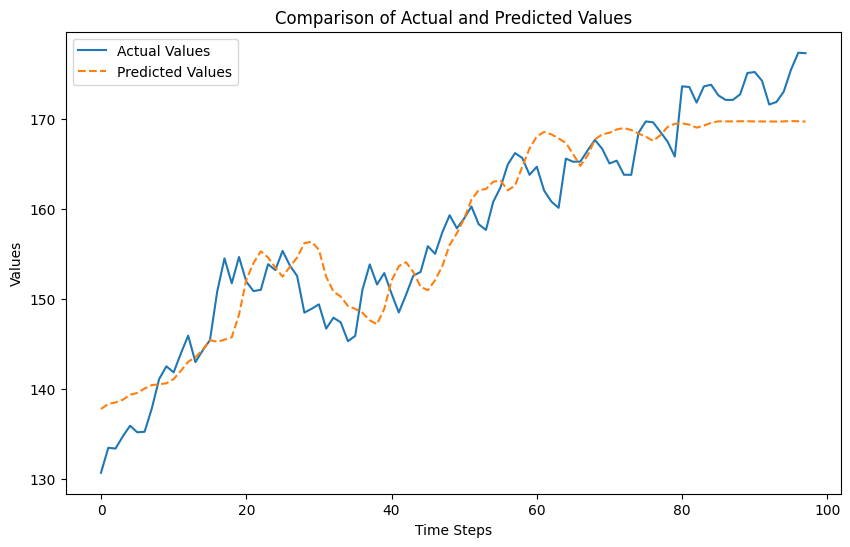

In [ ]:
x_axis = range(len(y_seq_original_scale))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_axis, y_seq_original_scale, label='Actual Values')
plt.plot(x_axis, predictions_original_scale, label='Predicted Values', linestyle='--')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()

- batch = 1, epoch = 1, predicting the training data
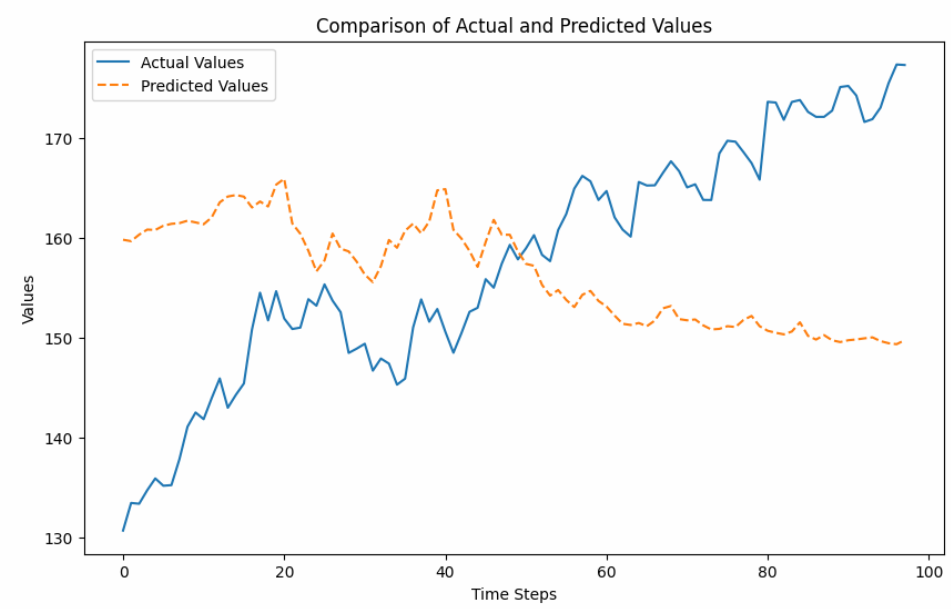

- batch=16, epoch=50 , predicting the training data
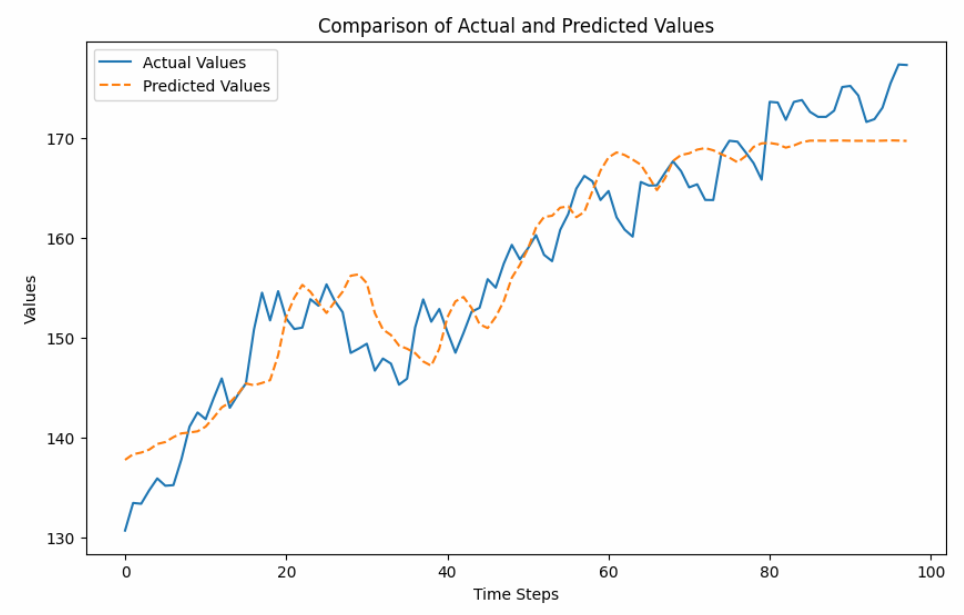

# multi-feature model, apply onto new data

In [ ]:
symbol = 'AAPL'
data = yf.download(symbol, start="2020-01-01", end="2021-12-31")['Close']

[*********************100%%**********************]  1 of 1 completed


In [ ]:
extracted_features = pd.DataFrame()

In [ ]:
extracted_features['lag_0'] = data.shift(1).reset_index(drop=True)
extracted_features['lag_2'] = data.shift(2).reset_index(drop=True)
extracted_features['lag_3'] = data.shift(3).reset_index(drop=True)

In [ ]:
extracted_features = extracted_features.ffill().bfill()

In [ ]:
len(test_selected_features)

20

In [ ]:
test_selected_features = extracted_features
test_selected_features_scaled = np.zeros_like(test_selected_features)

for i in range(test_selected_features.shape[1]):
    feature_column = test_selected_features.iloc[:,i].values.reshape(-1,1)
    scaled_feature = scalers[i].transform(feature_column)
    test_selected_features_scaled[:,i] = scaled_feature.reshape(-1)

test_selected_features_tensor = torch.FloatTensor(test_selected_features_scaled)


In [ ]:
test_selected_features_tensor = test_selected_features_tensor[:-1]

In [ ]:
test_selected_features_tensor.shape

torch.Size([503, 3])

In [ ]:
target = data.shift(-1).dropna().values
target_scaled = target_scaler.fit_transform(target.reshape(-1, 1))
target_tensor = torch.FloatTensor(target_scaled)
target_tensor.shape

torch.Size([503, 1])

In [ ]:
X_seq, y_seq = create_sequences(test_selected_features_tensor, target_tensor, seq_length)
data = TensorDataset(X_seq, y_seq)
test_loader = DataLoader(data, batch_size=batch_size, shuffle=False)

In [ ]:
predictions = test(model, test_loader)

# convert list of tensor to 2d numpy
predictions_tensor = torch.cat(predictions, dim=0)
predictions_2d = predictions_tensor.view(-1, 1)
predictions_numpy = predictions_2d.numpy()

predictions_original_scale = target_scaler.inverse_transform(predictions_numpy)


In [ ]:
y_seq_original_scale = target_scaler.inverse_transform(y_seq.view(-1, 1).numpy())

In [ ]:
len(y_seq_original_scale)

499

In [ ]:
len(predictions_original_scale)

499

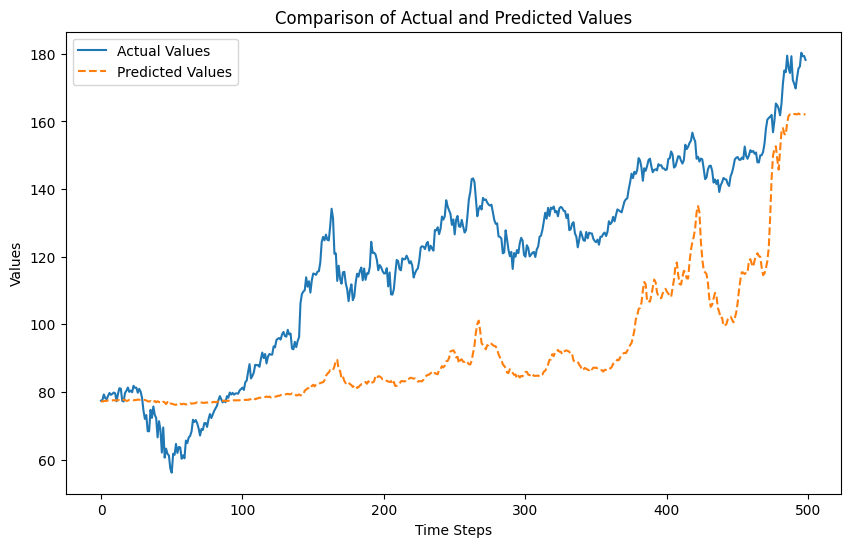

In [ ]:
x_axis = range(len(y_seq_original_scale))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_axis, y_seq_original_scale, label='Actual Values')
plt.plot(x_axis, predictions_original_scale, label='Predicted Values', linestyle='--')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()

- apply model to new data
- observation: the features are only lagged stock price, hence the prediction appear to always be lagged behind the prediction (i.e. actual to drop for a while before prediction drops). Also, it takes a long time for the prediction to start to pick up similar patterns as the actual; the initial periods of the prediction is essentially a horizontal line
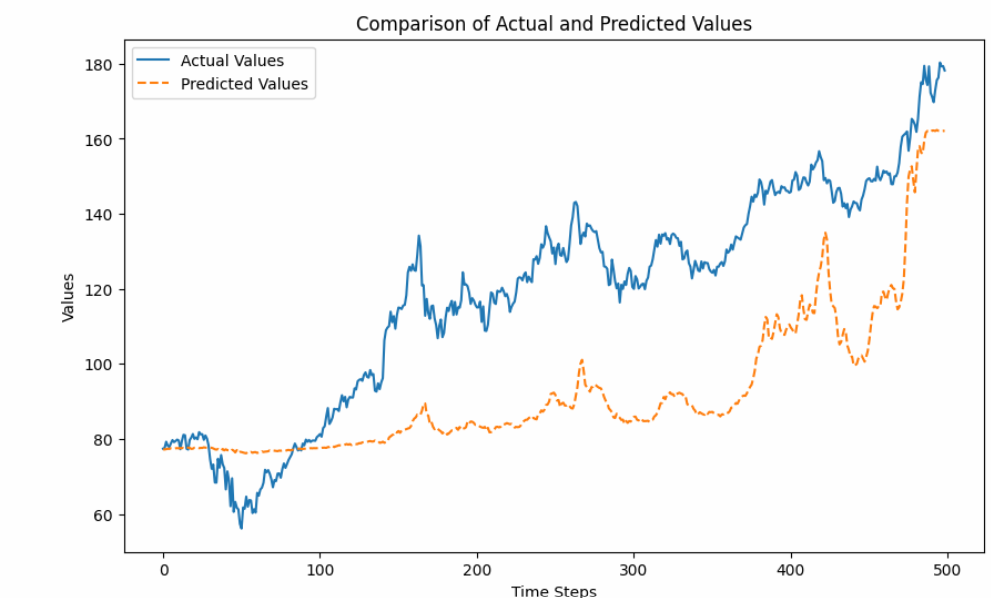

- apply model to new data
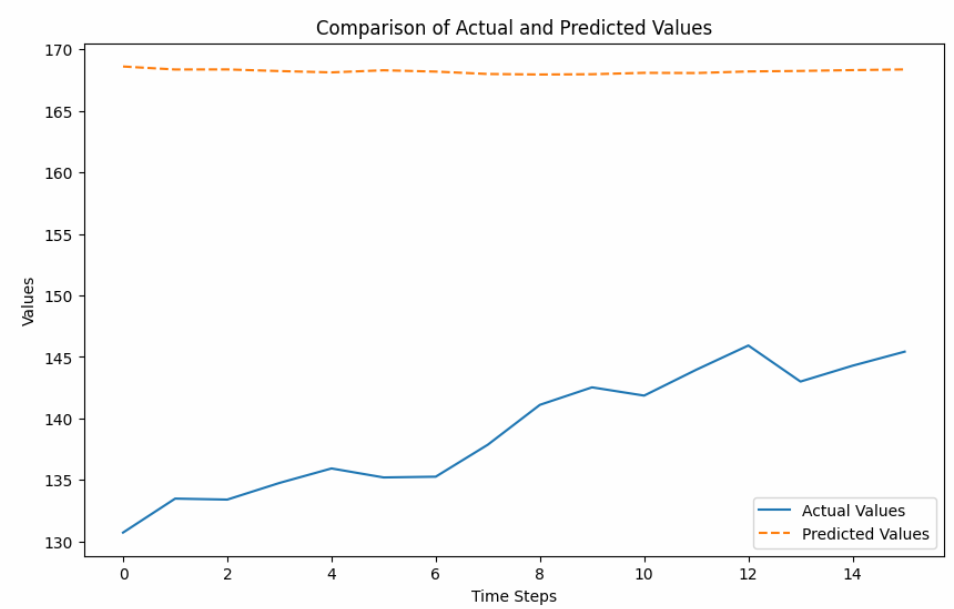